# Análise Exploratória de Dados (EDA) - Dados Meteorológicos

Este notebook faz análise exploratória completa dos dados meteorológicos do INMET.

**Funciona sem PostgreSQL** - usa dados diretamente do MinIO!


In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import read_from_minio, list_minio_files
import warnings
warnings.filterwarnings('ignore')

# Configurar visualizações
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

print(" Bibliotecas importadas!")


✅ Bibliotecas importadas!


## 1. Carregar Dados do MinIO


In [2]:
# Listar arquivos processados no MinIO
processed_files = list_minio_files('processed')
print(f"Arquivos processados encontrados: {len(processed_files)}")

# Carregar alguns arquivos (ou todos se quiser)
# Vamos carregar os primeiros 5 para análise rápida
arquivos_para_carregar = processed_files[:5] if len(processed_files) > 5 else processed_files

print(f"\nCarregando {len(arquivos_para_carregar)} arquivos...")

# Carregar e concatenar dados
all_data = []
for filename in arquivos_para_carregar:
    try:
        print(f"  Carregando: {filename[:50]}...")
        df = read_from_minio('processed', filename)
        all_data.append(df)
    except Exception as e:
        print(f"  Erro ao carregar {filename}: {str(e)}")

# Concatenar todos os dados
if all_data:
    df = pd.concat(all_data, ignore_index=True)
    print(f"\n Dados carregados: {len(df):,} registros")
    print(f"   Colunas: {len(df.columns)}")
else:
    print("\n Nenhum dado foi carregado!")
    print("   Execute primeiro o script de processamento.")


Arquivos processados encontrados: 65

Carregando 5 arquivos...
  Carregando: processed_upload_20251203_022758_dados_recife_2020...
  Carregando: processed_upload_20251203_022810_dados_arco_verde_...
  Carregando: processed_upload_20251203_022810_dados_cabrobo_202...
  Carregando: processed_upload_20251203_022811_dados_caruaru_202...
  Carregando: processed_upload_20251203_022812_dados_floresta_20...

✅ Dados carregados: 43,920 registros
   Colunas: 11


## 1.1. Extrair Cidade do Nome do Arquivo

**IMPORTANTE**: Execute esta célula ANTES da análise por cidade!


In [ ]:
# Extrair cidade do nome do arquivo (arquivo_origem)
if 'cidade' not in df.columns and 'arquivo_origem' in df.columns:
    print(" Extraindo cidade do nome do arquivo...")
    
    def extract_city(filename):
        """Extrai nome da cidade do nome do arquivo"""
        if pd.isna(filename):
            return 'Desconhecida'
        
        filename_str = str(filename).lower()
        
        # Padrões possíveis:
        # "dados_recife_2020.CSV" -> "recife"
        # "upload_20251203_dados_recife_2020.CSV" -> "recife"
        # "processed_upload_20251203_dados_recife_2020.CSV" -> "recife"
        
        if 'dados_' in filename_str:
            # Encontrar "dados_" e pegar a próxima parte
            parts = filename_str.split('dados_')
            if len(parts) > 1:
                # Pegar a parte após "dados_"
                after_dados = parts[1]
                # Separar por "_" e pegar a primeira parte (nome da cidade)
                city_name = after_dados.split('_')[0]
                # Remover extensões
                city_name = city_name.replace('.csv', '').replace('.', '')
                # Capitalizar primeira letra
                return city_name.capitalize()
        
        return 'Desconhecida'
    
    # Aplicar função
    df['cidade'] = df['arquivo_origem'].apply(extract_city)
    
    # Mostrar resultado
    cidades_unicas = df['cidade'].unique()
    print(f" Cidade extraída com sucesso!")
    print(f"   Cidades encontradas: {len(cidades_unicas)}")
    print(f"   Lista: {', '.join(sorted(cidades_unicas)[:15])}")
    print(f"\n   Distribuição:")
    print(df['cidade'].value_counts().head(10))
    
elif 'cidade' in df.columns:
    print(" Coluna 'cidade' já existe!")
    print(f"   Cidades: {df['cidade'].unique()[:10]}")
else:
    print(" Não foi possível extrair cidade.")
    print(f"   Colunas disponíveis: {list(df.columns)}")


## 2. Primeira Visualização dos Dados


In [3]:
# Ver primeiras linhas
print("Primeiras 5 linhas:")
print(df.head())

print("\n" + "="*50)
print("Informações do DataFrame:")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("Estatísticas Descritivas:")
print("="*50)
print(df.describe())


Primeiras 5 linhas:
    data_hora  temperatura  umidade_relativa  velocidade_vento  precipitacao  \
0  2020-01-01          NaN              71.0               NaN           0.0   
1  2020-01-01          NaN              71.0               NaN           0.0   
2  2020-01-01         27.0              73.0               NaN           0.0   
3  2020-01-01          NaN              77.0               NaN           0.0   
4  2020-01-01          NaN              87.0               NaN           NaN   

    ano  mes  dia  hora                                arquivo_origem  \
0  2020    1    1     0  upload_20251203_022758_dados_recife_2020.CSV   
1  2020    1    1     0  upload_20251203_022758_dados_recife_2020.CSV   
2  2020    1    1     0  upload_20251203_022758_dados_recife_2020.CSV   
3  2020    1    1     0  upload_20251203_022758_dados_recife_2020.CSV   
4  2020    1    1     0  upload_20251203_022758_dados_recife_2020.CSV   

              processing_date  
0  2025-12-03T02:33:38.34392

## 3. Análise de Dados Faltantes


Dados Faltantes por Coluna:
             Coluna  Valores Faltantes  Percentual (%)
1       temperatura              39733       90.466758
3  velocidade_vento              36855       83.913934
4      precipitacao               9262       21.088342
2  umidade_relativa               1869        4.255464


<Figure size 1200x600 with 0 Axes>

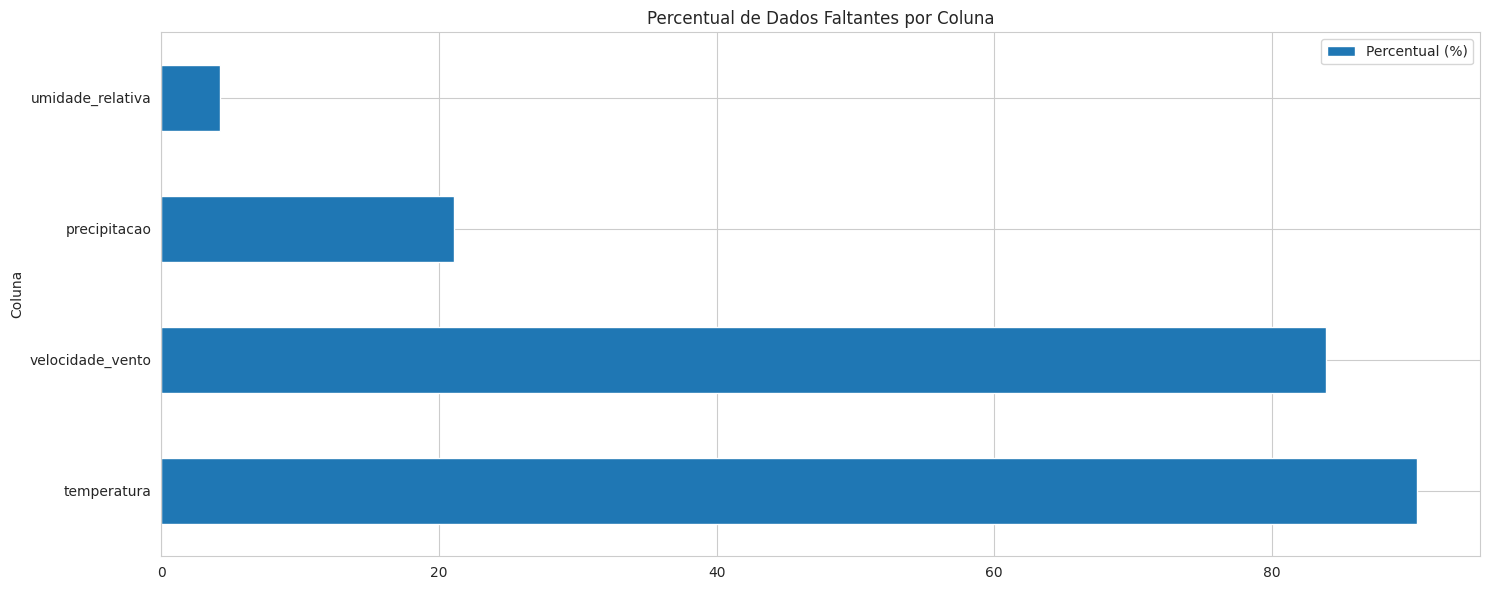

In [4]:
# Verificar dados faltantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Coluna': missing.index,
    'Valores Faltantes': missing.values,
    'Percentual (%)': missing_pct.values
}).sort_values('Valores Faltantes', ascending=False)

print("Dados Faltantes por Coluna:")
print(missing_df[missing_df['Valores Faltantes'] > 0])

# Visualizar
if len(missing_df[missing_df['Valores Faltantes'] > 0]) > 0:
    plt.figure(figsize=(12, 6))
    missing_df[missing_df['Valores Faltantes'] > 0].plot(
        x='Coluna', 
        y='Percentual (%)', 
        kind='barh',
        title='Percentual de Dados Faltantes por Coluna'
    )
    plt.tight_layout()
    plt.show()
else:
    print("\n Nenhum dado faltante encontrado!")


## 4. Distribuições das Variáveis Principais


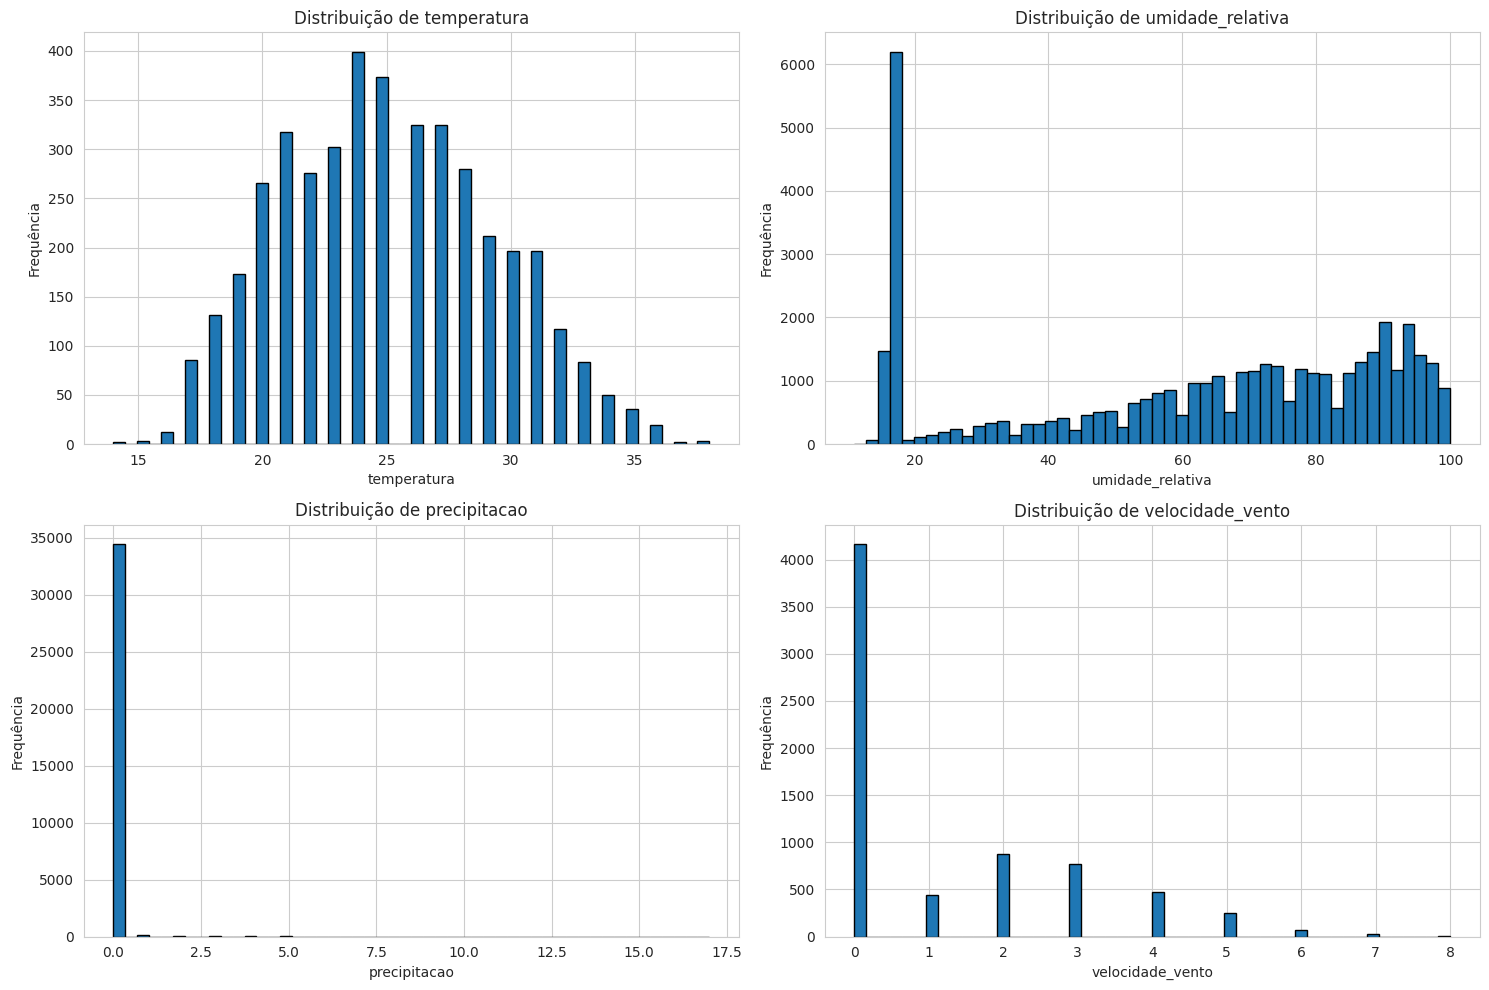

In [5]:
# Variáveis numéricas principais
variaveis = ['temperatura', 'umidade_relativa', 'precipitacao', 'velocidade_vento']
variaveis_disponiveis = [v for v in variaveis if v in df.columns]

if variaveis_disponiveis:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, var in enumerate(variaveis_disponiveis[:4]):
        if var in df.columns:
            df[var].hist(bins=50, ax=axes[i], edgecolor='black')
            axes[i].set_title(f'Distribuição de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()
else:
    print("Variáveis não encontradas. Verifique os nomes das colunas.")
    print(f"Colunas disponíveis: {list(df.columns)[:10]}")


## 5. Análise por Cidade


In [ ]:
# PRIMEIRO: Extrair cidade do nome do arquivo se não existir
if 'cidade' not in df.columns and 'arquivo_origem' in df.columns:
    print(" Extraindo cidade do nome do arquivo...")
    
    def extract_city(filename):
        """Extrai nome da cidade do nome do arquivo"""
        if pd.isna(filename):
            return 'Desconhecida'
        filename_str = str(filename).lower()
        # Padrão: "dados_NOMECIDADE_ano" ou "upload_..._dados_NOMECIDADE_ano"
        if 'dados_' in filename_str:
            parts = filename_str.split('dados_')
            if len(parts) > 1:
                city_name = parts[1].split('_')[0]
                city_name = city_name.replace('.csv', '').replace('.', '')
                return city_name.capitalize()
        return 'Desconhecida'
    
    df['cidade'] = df['arquivo_origem'].apply(extract_city)
    print(f" Cidade extraída! Cidades: {', '.join(df['cidade'].unique()[:10])}")

# AGORA: Fazer análise por cidade
if 'cidade' in df.columns:
    # Temperatura média por cidade
    if 'temperatura' in df.columns:
        temp_por_cidade = df.groupby('cidade')['temperatura'].agg(['mean', 'std', 'min', 'max']).sort_values('mean', ascending=False)
        
        print("\n" + "="*50)
        print("Temperatura Média por Cidade:")
        print("="*50)
        print(temp_por_cidade)
        
        # Visualizar
        plt.figure(figsize=(12, 6))
        temp_por_cidade['mean'].plot(kind='barh', title='Temperatura Média por Cidade')
        plt.xlabel('Temperatura Média (°C)')
        plt.ylabel('Cidade')
        plt.tight_layout()
        plt.show()
    
    # Contagem de registros por cidade
    print("\n" + "="*50)
    print("Registros por Cidade:")
    print("="*50)
    registros_por_cidade = df['cidade'].value_counts()
    print(registros_por_cidade)
    
    plt.figure(figsize=(12, 6))
    registros_por_cidade.plot(kind='bar', title='Número de Registros por Cidade')
    plt.xlabel('Cidade')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print(" Não foi possível extrair cidade.")
    print(f"Colunas disponíveis: {list(df.columns)}")
    print("\n Verifique se a coluna 'arquivo_origem' existe.")


Coluna 'cidade' não encontrada.
Colunas disponíveis: ['data_hora', 'temperatura', 'umidade_relativa', 'velocidade_vento', 'precipitacao', 'ano', 'mes', 'dia', 'hora', 'arquivo_origem', 'processing_date']


## 6. Análise Temporal (Série Temporal)


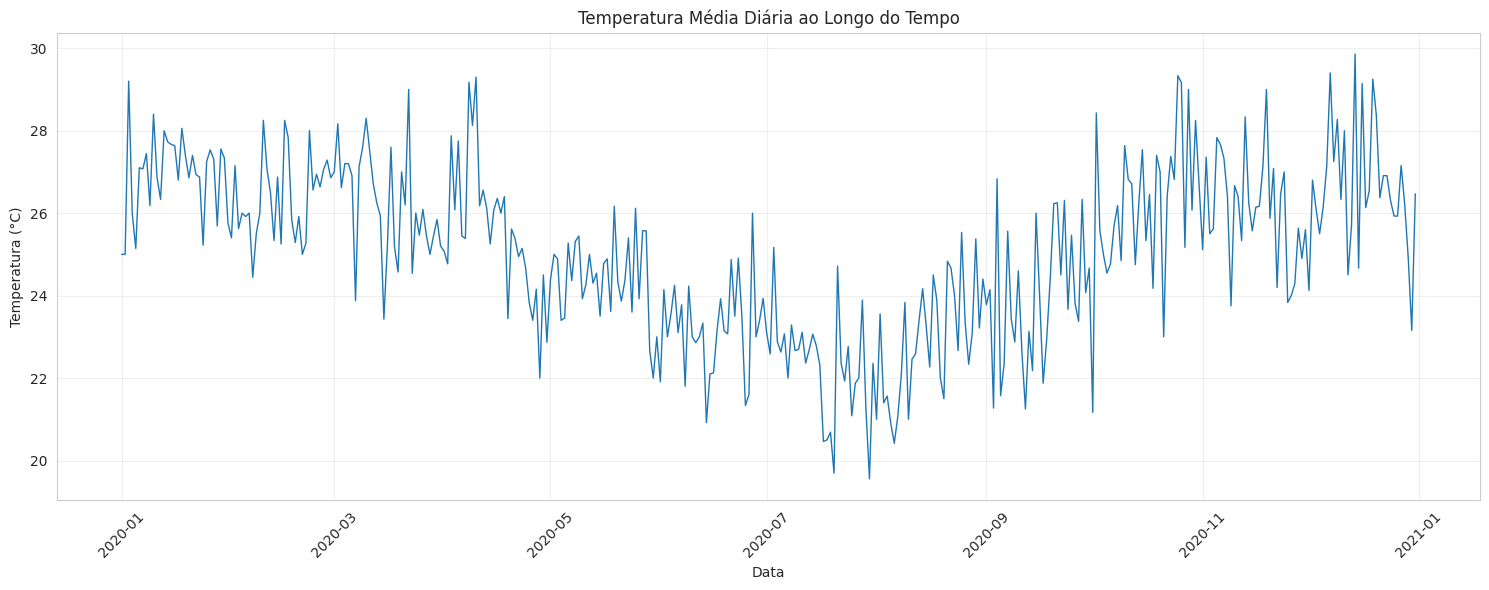

Período de dados: 2020-01-01 00:00:00 até 2020-12-31 00:00:00


In [7]:
# Converter data_hora se necessário
if 'data_hora' in df.columns:
    df['data_hora'] = pd.to_datetime(df['data_hora'], errors='coerce')
    
    # Agrupar por data (média diária)
    df_diario = df.groupby(df['data_hora'].dt.date)['temperatura'].mean()
    
    # Visualizar série temporal
    plt.figure(figsize=(15, 6))
    plt.plot(df_diario.index, df_diario.values, linewidth=1)
    plt.title('Temperatura Média Diária ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Temperatura (°C)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Período de dados: {df['data_hora'].min()} até {df['data_hora'].max()}")
else:
    print("Coluna 'data_hora' não encontrada.")


## 7. Matriz de Correlação


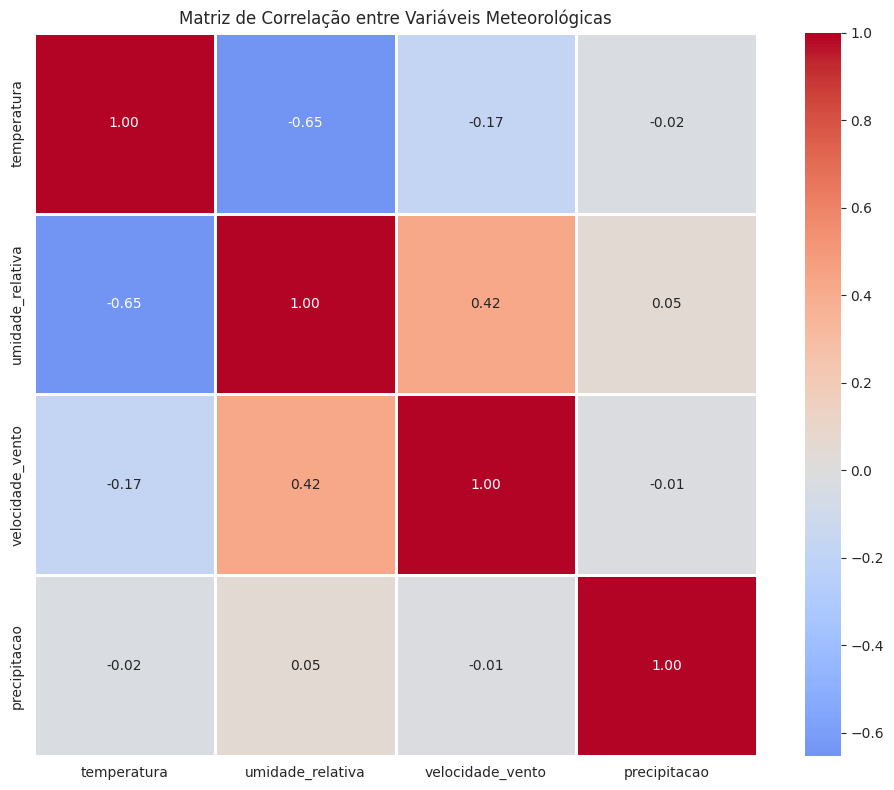


Correlações com Temperatura:
temperatura         1.000000
precipitacao       -0.024462
velocidade_vento   -0.172769
umidade_relativa   -0.653105
Name: temperatura, dtype: float64


In [8]:
# Selecionar variáveis numéricas para correlação
numeric_cols = ['temperatura', 'umidade_relativa', 'pressao_atmosferica', 
                'velocidade_vento', 'radiacao_solar', 'precipitacao']
available_cols = [col for col in numeric_cols if col in df.columns]

if len(available_cols) >= 2:
    # Calcular correlação
    corr = df[available_cols].corr()
    
    # Visualizar
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, fmt='.2f')
    plt.title('Matriz de Correlação entre Variáveis Meteorológicas')
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelações com Temperatura:")
    if 'temperatura' in corr.columns:
        print(corr['temperatura'].sort_values(ascending=False))
else:
    print(f"Variáveis numéricas insuficientes. Encontradas: {available_cols}")


## 8. Resumo e Conclusões

Execute esta célula para ver um resumo final da análise.


In [9]:
print("="*60)
print("RESUMO DA ANÁLISE EXPLORATÓRIA")
print("="*60)
print(f"\n Total de registros analisados: {len(df):,}")
print(f"📅 Período: {df['data_hora'].min() if 'data_hora' in df.columns else 'N/A'} até {df['data_hora'].max() if 'data_hora' in df.columns else 'N/A'}")
print(f"🏙  Cidades: {df['cidade'].nunique() if 'cidade' in df.columns else 'N/A'}")

if 'temperatura' in df.columns:
    print(f"\n🌡  Temperatura:")
    print(f"   Média: {df['temperatura'].mean():.2f}°C")
    print(f"   Mínima: {df['temperatura'].min():.2f}°C")
    print(f"   Máxima: {df['temperatura'].max():.2f}°C")

if 'umidade_relativa' in df.columns:
    print(f"\n💧 Umidade Relativa:")
    print(f"   Média: {df['umidade_relativa'].mean():.2f}%")

if 'precipitacao' in df.columns:
    print(f"\n🌧  Precipitação:")
    print(f"   Total: {df['precipitacao'].sum():.2f}mm")
    print(f"   Média: {df['precipitacao'].mean():.2f}mm")

print("\n Análise exploratória concluída!")
print("="*60)


RESUMO DA ANÁLISE EXPLORATÓRIA

📊 Total de registros analisados: 43,920
📅 Período: 2020-01-01 00:00:00 até 2020-12-31 00:00:00
🏙️  Cidades: N/A

🌡️  Temperatura:
   Média: 25.04°C
   Mínima: 14.00°C
   Máxima: 38.00°C

💧 Umidade Relativa:
   Média: 62.32%

🌧️  Precipitação:
   Total: 546.00mm
   Média: 0.02mm

✅ Análise exploratória concluída!
